In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


from models.t0 import T0RegressionModel
from datahandles import TabLLMDataObject, FewshotTabLLMDataset, CombinedTabLLMTextDataset
from tabllm.dataset_utils import load_dataset, balance_dataset, load_and_preprocess_dataset
from utils import Config, ConfigObject

os.environ["HF_HOME"] = "/export/pasan/.cache/huggingface"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=False, cmap='Blues'):
    """
    Displays a confusion matrix.

    Parameters:
    - y_true: list or array of true labels
    - y_pred: list or array of predicted labels
    - class_names: list of class names (optional)
    - normalize: whether to normalize the matrix (default: False)
    - cmap: color map for the heatmap
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap,
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.tight_layout()
    plt.show()

In [9]:
ds_name = "bank"
checkpoint_path = f"save/t0pp-{ds_name}-finonly/epoch-1.pth"

checkpoint = torch.load(checkpoint_path, weights_only=False)

cfg_dict = checkpoint["cfg"]
cfg_dict["datasets"]["balanced"] = {"train": True, "val": False, "test": True}
cfg_dict["datasets"]["tabllm"]["txt_data_path"] = "tabllm/data/datasets_serialized"
cfg_dict["datasets"]["test_ratio"] = 0.8
cfg_dict["datasets"]["validation_ratio"] = 0.1
cfg_dict["debug"] = False
cfg = Config(cfg_dict=cfg_dict)

tabllm_do = TabLLMDataObject(cfg=cfg, set_hyponet_in_dim=True)
test_ds = CombinedTabLLMTextDataset(cfg=cfg, split="test", datapoints=[tabllm_do.split_datapoints[ds_name]], max_n_features=cfg.hyponet.in_dim())

y = np.array([test_ds[i]["y"] for i in range(len(test_ds))])
X = np.array([test_ds[i]["x"] for i in range(len(test_ds))])
print(f"X.shape: {X.shape}, y.shape: {y.shape}")

X.shape: (8520, 103), y.shape: (8520,)


In [ ]:
model = T0RegressionModel(cfg=cfg)
model.load_state_dict(checkpoint['model'])
tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer.model())

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [13]:
print(test_ds[1, True])

Example: The age is 51. The type of job is services. The marital status is divorced. The education is secondary. The has credit in default? is no. The average yearly balance, in euros is 242. The has housing loan? is no. The has personal loan? is yes. The contact communication type is cellular. The last contact day of the month is 14. The last contact month of year is jul. The last contact duration, in seconds is 1336. The number of contacts performed during this campaign and for this client is. The number of days that passed by after the client was last contacted from a previous campaign is client was not previously contacted. The number of contacts performed before this campaign and for this client is 0. The outcome of the previous marketing campaign is unknown.

Does this client subscribe to a term deposit? Yes or no? Answer:
|||
Yes



Dataset: bank
Prediction shape: (8520,)
Max const. predictor acc: 50.00
Hyponet balanced acc: 50.00
Hyponet F1 score: 0.00
Hyponet unbalanced acc: 50.00


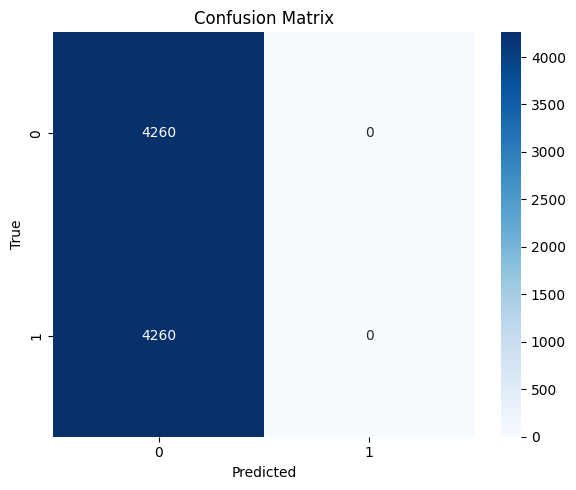

In [11]:
prompt = "".join([test_ds[i, True] for i in np.random.randint(low=0, high=len(test_ds), size=128)])
# prompt = "sdjhf skdjfhsd akfjal"
tokens = tokenizer(prompt, 
                   truncation=cfg.tokenizer.truncation(), 
                   padding=cfg.tokenizer.padding(), 
                   max_length=cfg.tokenizer.max_length(), 
                   return_tensors='pt')
hyponet = model(tokens)
hyponet.eval()
preds = hyponet.forward(torch.Tensor(X).unsqueeze(dim=0))
preds = preds.detach().numpy()
preds = np.squeeze(preds)
preds = np.argmax(preds, axis=1)

print(f"Dataset: {ds_name}")
print(f"Prediction shape: {preds.shape}")

val_counts = pd.DataFrame(y).value_counts()
print(f"Max const. predictor acc: {max(val_counts)/sum(val_counts) * 100:.2f}")
print(f"Hyponet balanced acc: {balanced_accuracy_score(y, preds) * 100:.2f}")
print(f"Hyponet F1 score: {f1_score(y, preds) * 100:.2f}")
print(f"Hyponet unbalanced acc: {accuracy_score(y, preds) * 100:.2f}")

plot_confusion_matrix(y_true=y, y_pred=preds)